<a href="https://colab.research.google.com/github/Rqkko/time-series-forecasting/blob/main/timeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Download Nikkei 225 Data
symbol = "^N225"
start_date = "2000-01-01"
end_date = "2025-05-31"
data = yf.download(symbol, start=start_date, end=end_date)
data.head()

/tmp/ipython-input-2-2844239282.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^N225,^N225,^N225,^N225,^N225
Date,,,,,
2000-01-04,19002.859375,19187.609375,18937.449219,18937.449219,0
2000-01-05,18542.550781,19003.509766,18221.820312,19003.509766,0
2000-01-06,18168.269531,18582.740234,18168.269531,18574.009766,0
2000-01-07,18193.410156,18285.730469,18068.099609,18194.050781,0
2000-01-11,18850.919922,18887.560547,18246.099609,18246.099609,0


In [3]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,^N225,^N225,^N225,^N225,^N225
Date,,,,,
2025-05-26,37531.531250,37531.531250,37167.011719,37209.261719,89900000
2025-05-27,37724.109375,37769.050781,37411.679688,37523.371094,86200000
2025-05-28,37722.398438,38178.730469,37709.710938,38094.789062,122600000
2025-05-29,38432.980469,38454.070312,38035.320312,38046.968750,133200000
2025-05-30,37965.101562,38114.468750,37748.171875,37912.488281,204300000


In [4]:
# Keep only closing prices
df = data[["Close"]].copy()
df.rename(columns={"Close": "Price"}, inplace=True)
df.head()

Price,Price
Ticker,^N225
Date,
2000-01-04,19002.859375
2000-01-05,18542.550781
2000-01-06,18168.269531
2000-01-07,18193.410156
2000-01-11,18850.919922


In [5]:
# Calculate daily returns
df["Return"] = df["Price"].pct_change()

# Apply log transformation for variance stabilization
df["LogPrice"] = np.log(df["Price"])
df["LogReturn"] = df["LogPrice"].diff()

# Handle missing values
df.ffill(inplace=True)  # Forward fill
df.dropna(inplace=True)  # Drop any remaining NaNs
df.head()

Price,Price,Return,LogPrice,LogReturn
Ticker,^N225,,,
Date,,,,
2000-01-05,18542.550781,-0.024223,9.827823,-0.024521
2000-01-06,18168.269531,-0.020185,9.807432,-0.020391
2000-01-07,18193.410156,0.001384,9.808815,0.001383
2000-01-11,18850.919922,0.036140,9.844317,0.035502
2000-01-12,18677.419922,-0.009204,9.835071,-0.009246


<Figure size 1400x400 with 0 Axes>

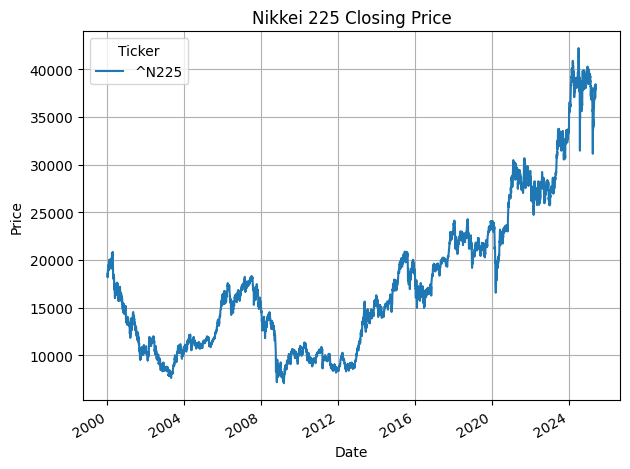

In [6]:
# Price over time
plt.figure(figsize=(14, 4))
df["Price"].plot(title="Nikkei 225 Closing Price", ylabel="Price", xlabel="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

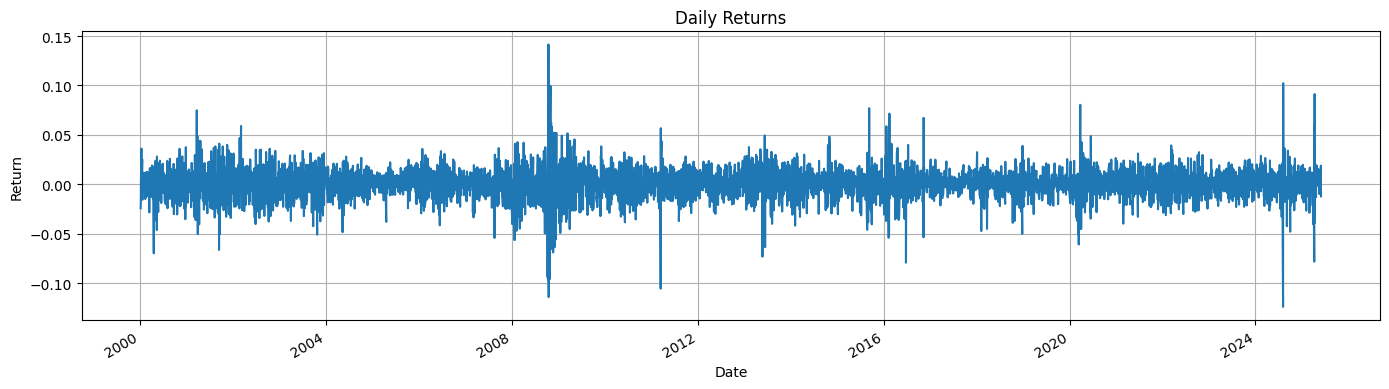

In [7]:
# Daily returns over time
plt.figure(figsize=(14, 4))
df["Return"].plot(title="Daily Returns", ylabel="Return", xlabel="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

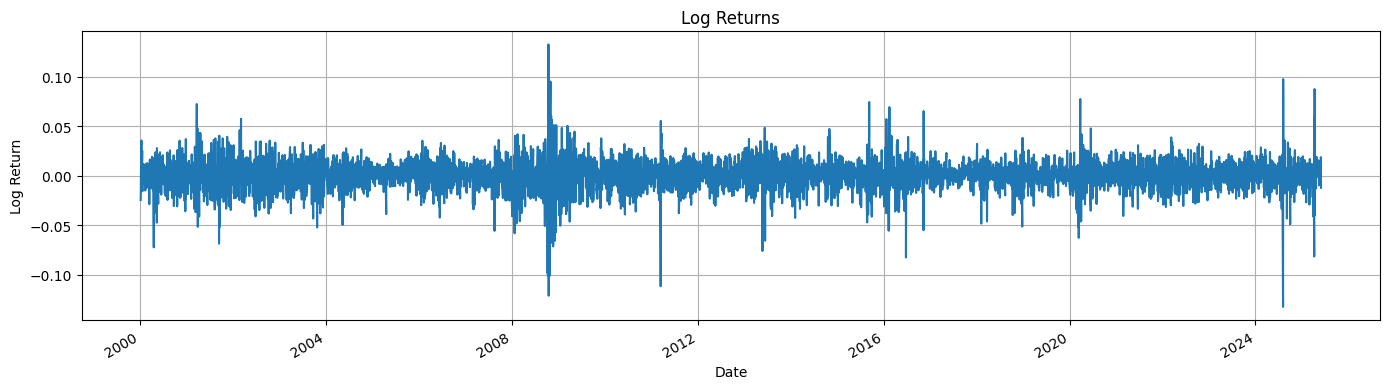

In [8]:
# Log returns over time
plt.figure(figsize=(14, 4))
df["LogReturn"].plot(title="Log Returns", ylabel="Log Return", xlabel="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

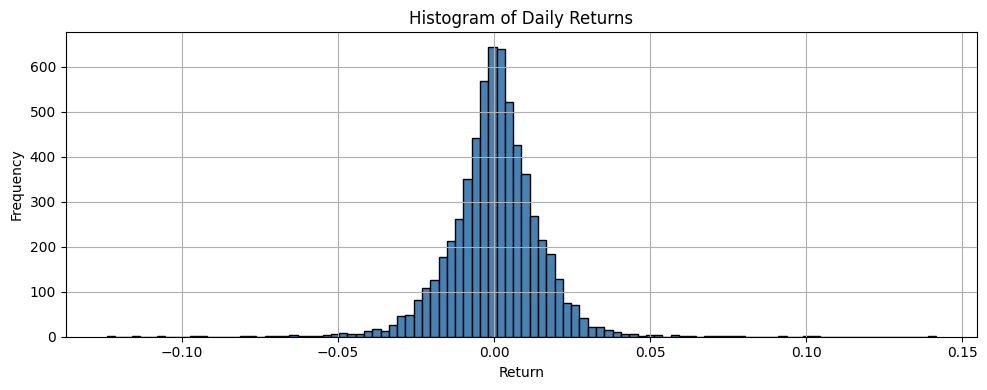

In [9]:
# Histogram of returns
plt.figure(figsize=(10, 4))
plt.hist(df["Return"], bins=100, color='steelblue', edgecolor='black')
plt.title("Histogram of Daily Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

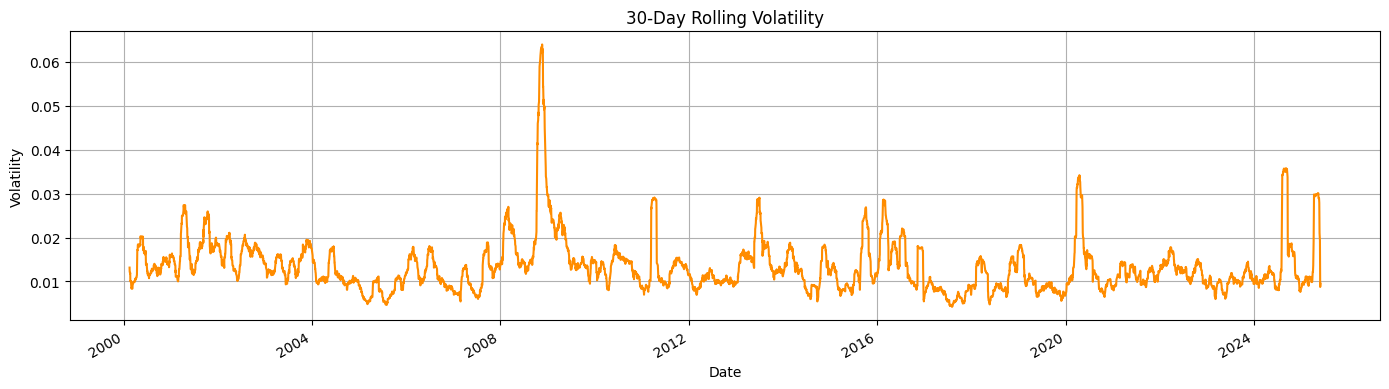

In [10]:
# Rolling volatility (30-day std of returns)
df["Volatility"] = df["Return"].rolling(window=30).std()

plt.figure(figsize=(14, 4))
df["Volatility"].plot(title="30-Day Rolling Volatility", ylabel="Volatility", xlabel="Date", color='darkorange')
plt.grid(True)
plt.tight_layout()
plt.show()

# Models

In [11]:
# Model Evaluation
def evaluate_forecast(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"Evaluation for {model_name}:")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    return {"model": model_name, "MAE": mae, "RMSE": rmse, "MAPE": mape}

## Benchmark Models

### Naive Forecast

In [12]:
#Naive model

# If your columns are still multi-indexed, flatten them again (just in case)
df.columns = [col[0] for col in df.columns]

# Recreate the NaiveForecast column
df["NaiveForecast"] = df["Price"].shift(1)

# Recreate the DataFrame used for evaluation
naive_df = df.dropna(subset=["NaiveForecast"])

In [13]:
# Zoom into recent data
naive_df_zoom = naive_df.loc["2023-01-01":"2025-05-31"]

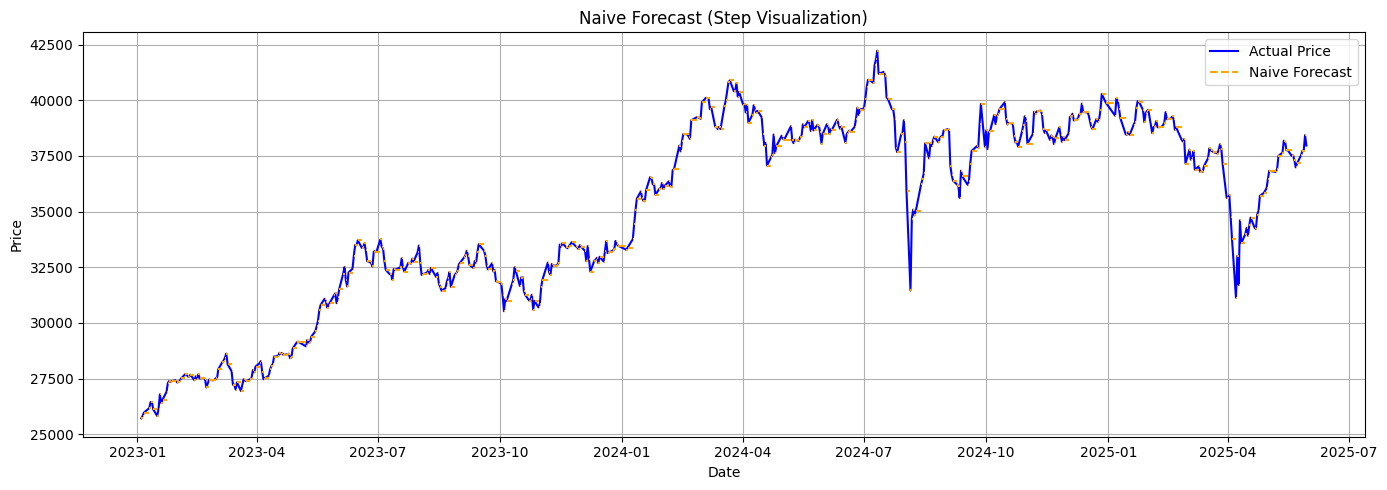

In [14]:
plt.figure(figsize=(14, 5))
plt.plot(naive_df_zoom.index, naive_df_zoom["Price"], label="Actual Price", color="blue")

# Draw horizontal lines for each naive prediction (step-style)
for i in range(1, len(naive_df_zoom)):
    x_vals = [naive_df_zoom.index[i-1], naive_df_zoom.index[i]]
    y_vals = [naive_df_zoom["NaiveForecast"].iloc[i]] * 2
    plt.plot(x_vals, y_vals, color="orange", linestyle="--")

plt.title("Naive Forecast (Step Visualization)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(["Actual Price", "Naive Forecast"])
plt.grid(True)
plt.tight_layout()
plt.show()

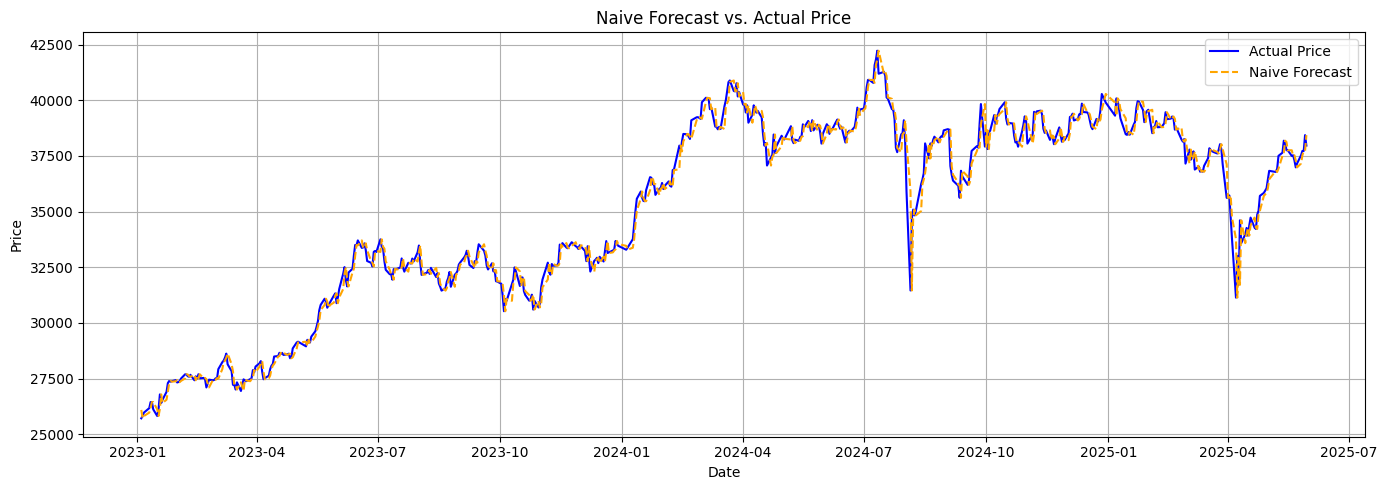

In [15]:
plt.figure(figsize=(14, 5))
plt.plot(naive_df_zoom.index, naive_df_zoom["Price"], label="Actual Price", color="blue")
plt.plot(naive_df_zoom.index, naive_df_zoom["NaiveForecast"], label="Naive Forecast", color="orange", linestyle="--")

plt.title("Naive Forecast vs. Actual Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Evaluate
results_naive = evaluate_forecast(
    y_true=naive_df["Price"],
    y_pred=naive_df["NaiveForecast"],
    model_name="Naive"
)

Evaluation for Naive:
MAE:  173.18
RMSE: 262.44
MAPE: 1.04%


### SMA

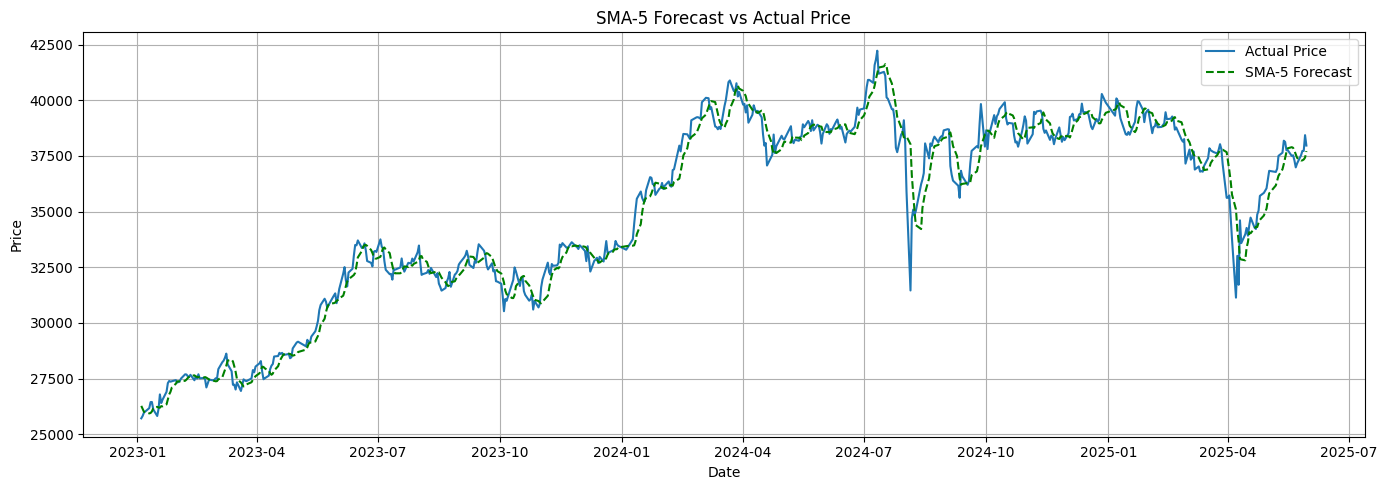

SMA-5 Model MAE: 259.0134
SMA-5 Model RMSE: 377.7869
SMA-3: MAE = 217.38
SMA-5: MAE = 259.01
SMA-10: MAE = 341.01
SMA-20: MAE = 457.67
SMA-30: MAE = 547.26


In [17]:
# Define SMA window size (e.g., 5 days)
window_size = 5

# SMA forecast: mean of last `window_size` prices
df["SMAForecast"] = df["Price"].shift(1).rolling(window=window_size).mean()

# Drop rows with NaN due to shift and rolling
sma_df = df.dropna(subset=["SMAForecast"])

# Plot actual vs SMA forecast (zoom into recent)
sma_df_zoom = sma_df.loc["2023-01-01":"2025-05-31"]

plt.figure(figsize=(14, 5))
plt.plot(sma_df_zoom.index, sma_df_zoom["Price"], label="Actual Price")
plt.plot(sma_df_zoom.index, sma_df_zoom["SMAForecast"], label=f"SMA-{window_size} Forecast", linestyle="--", color="green")
plt.title(f"SMA-{window_size} Forecast vs Actual Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_sma = mean_absolute_error(sma_df["Price"], sma_df["SMAForecast"])
rmse_sma = np.sqrt(mean_squared_error(sma_df["Price"], sma_df["SMAForecast"]))

print(f"SMA-{window_size} Model MAE: {mae_sma:.4f}")
print(f"SMA-{window_size} Model RMSE: {rmse_sma:.4f}")

for window_size in [3, 5, 10, 20, 30]:
    forecast = df["Price"].shift(1).rolling(window=window_size).mean()
    valid = df[~forecast.isna()]
    mae = mean_absolute_error(valid["Price"], forecast.dropna())
    print(f"SMA-{window_size}: MAE = {mae:.2f}")

In [18]:
# Evaluate
results_sma = evaluate_forecast(
    y_true=sma_df["Price"],
    y_pred=sma_df["SMAForecast"],
    model_name="SMA"
)

Evaluation for SMA:
MAE:  259.01
RMSE: 377.79
MAPE: 1.55%


## Classical Models

### Holt-Winters

In [19]:
!pip install statsmodels

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [20]:
# Ensure index is datetime and data is at a regular frequency
df = df.asfreq('B')  # Business days (adjust if needed)
df["Price"] = df["Price"].ffill()

# Pick recent data for faster model training
train_data = df["Price"].loc["2003-01-01":"2022-12-31"]

# Choose seasonal period (e.g., 252 for yearly if daily data, 5 for weekly)
seasonal_period = 252

# 🔹 ADDITIVE Holt-Winters model
model_add = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=seasonal_period)
fit_add = model_add.fit()

# 🔹 MULTIPLICATIVE Holt-Winters model
model_mul = ExponentialSmoothing(train_data, trend='add', seasonal='mul', seasonal_periods=seasonal_period)
fit_mul = model_mul.fit()

# Forecast next N days
forecast_horizon = df.loc["2023-01-01":"2025-05-30"].shape[0]
forecast_add = fit_add.forecast(forecast_horizon)
forecast_mul = fit_mul.forecast(forecast_horizon)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


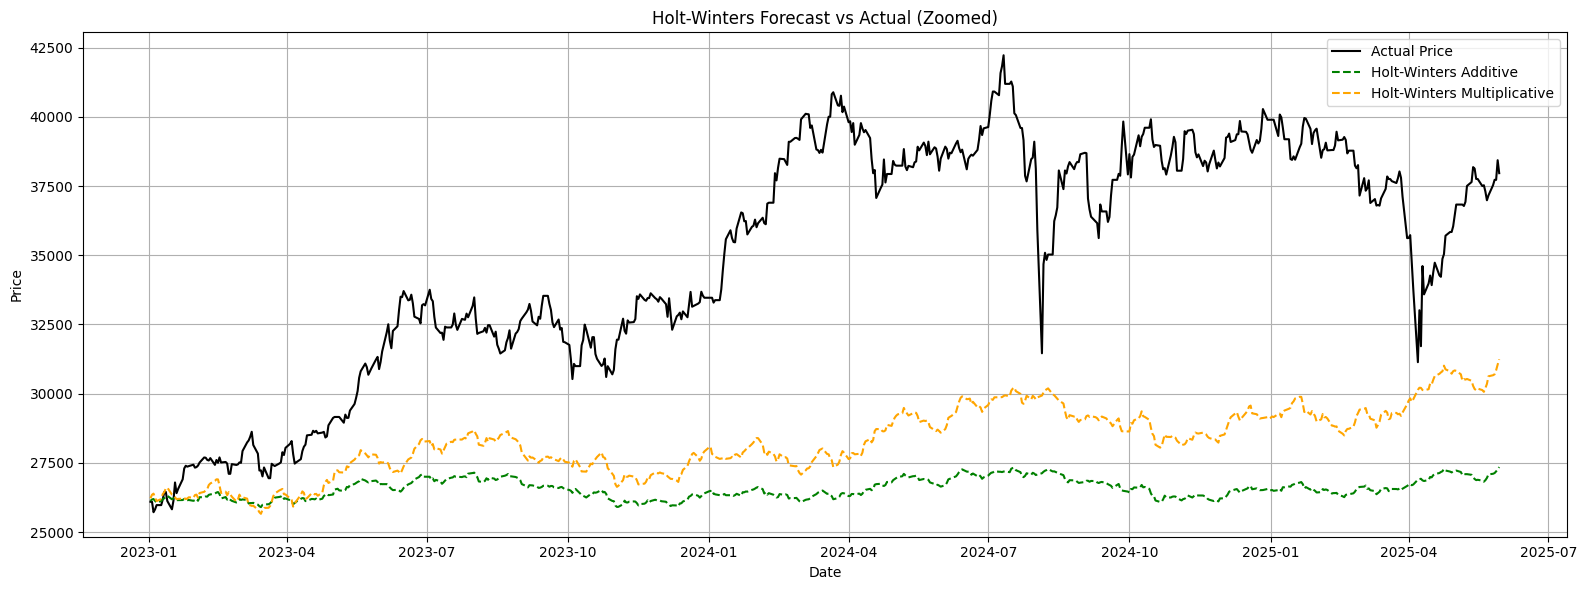

In [21]:
test_data_subset = df["Price"].loc[forecast_add.index]

# Define zoom range
zoom_start = "2023-01-01"
zoom_end = "2025-05-30"

# Actual price in zoom range
actual_zoom = df["Price"].loc[zoom_start:zoom_end]

# Filter forecasts to the same range (align indices)
forecast_add_zoom = forecast_add.loc[zoom_start:zoom_end]
forecast_mul_zoom = forecast_mul.loc[zoom_start:zoom_end]

# Plot
plt.figure(figsize=(16, 6))
plt.plot(actual_zoom.index, actual_zoom, label="Actual Price", color="black")
plt.plot(forecast_add_zoom.index, forecast_add_zoom, label="Holt-Winters Additive", linestyle='--', color="green")
plt.plot(forecast_mul_zoom.index, forecast_mul_zoom, label="Holt-Winters Multiplicative", linestyle='--', color="orange")
plt.title("Holt-Winters Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Evaluate
results_hw_add = evaluate_forecast(
    y_true=test_data_subset,
    y_pred=forecast_add,
    model_name="Holt-Winters Additive"
)

results_hw_mul = evaluate_forecast(
    y_true=test_data_subset,
    y_pred=forecast_mul,
    model_name="Holt-Winters Multiplicative"
)

Evaluation for Holt-Winters Additive:
MAE:  8440.81
RMSE: 9376.16
MAPE: 22.97%
Evaluation for Holt-Winters Multiplicative:
MAE:  6748.71
RMSE: 7561.84
MAPE: 18.35%


### ARIMA

ARIMA   RMSE: 9375.31, MAE: 8484.62
ARIMAX  RMSE: 9812.36, MAE: 8935.75
SARIMAX RMSE: 9001.84, MAE: 8156.86


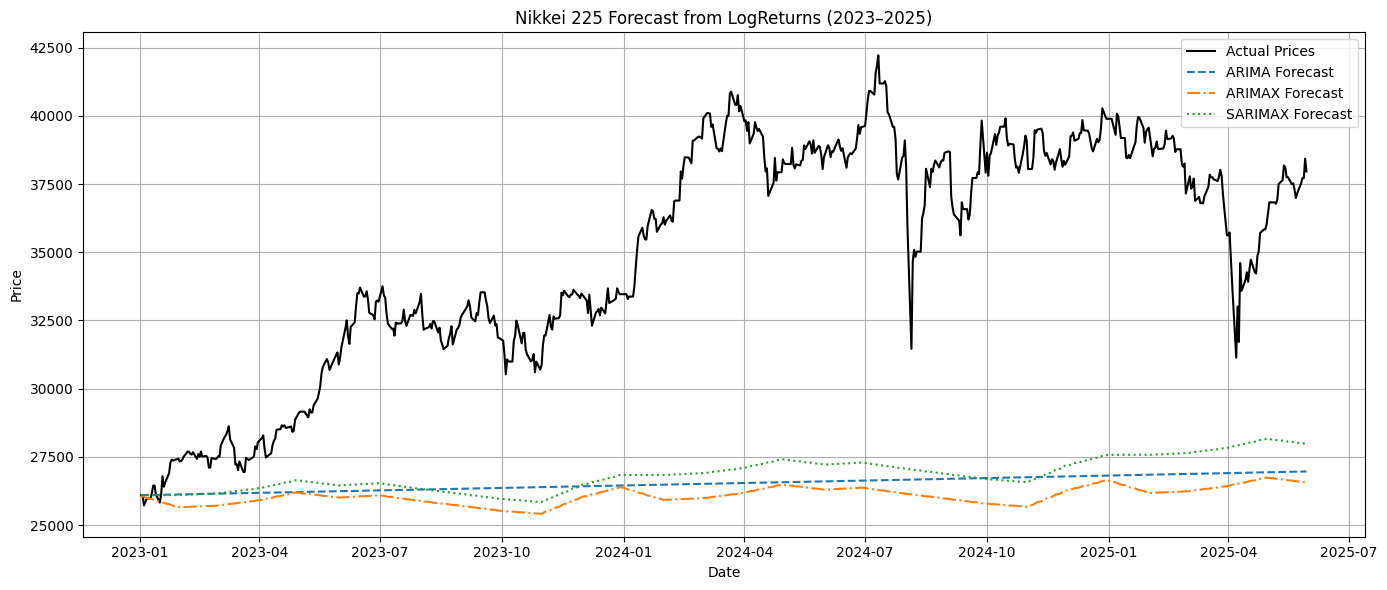

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Add month dummies as exogenous features
df["month"] = df.index.month
month_dummies = pd.get_dummies(df["month"], prefix="month", drop_first=True)
month_dummies = month_dummies.astype(int)
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
df = pd.concat([df, month_dummies], axis=1)

# Use LogReturn as target
train = df["LogReturn"][:'2022']
test = df["LogReturn"]['2023':]
train_exog = df.loc[:'2022', month_dummies.columns]
test_exog = df.loc['2023':, month_dummies.columns]
actual_prices = np.exp(test)  # convert log-prices back to prices for evaluation
last_train_price = df.loc[train.index[-1], "Price"]

train = train.astype(float)
test = test.astype(float)
train_exog = train_exog.astype(float)
test_exog = test_exog.astype(float)

# ARIMA
arima_model = ARIMA(train, order=(1, 0, 1))  # no differencing since LogReturn is already diffed
arima_result = arima_model.fit()
arima_log_returns = arima_result.forecast(steps=len(test))

# ARIMAX
arimax_model = ARIMA(train, order=(1, 0, 1), exog=train_exog)
arimax_result = arimax_model.fit()
arimax_log_returns = arimax_result.forecast(steps=len(test), exog=test_exog)

# SARIMAX
sarimax_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12), exog=train_exog)
sarimax_result = sarimax_model.fit()
sarimax_log_returns = sarimax_result.forecast(steps=len(test), exog=test_exog)

# Reconstruct prices from predicted log returns
def reconstruct_prices(log_returns, start_price):
    cumulative = np.exp(np.cumsum(log_returns))
    return start_price * cumulative

actual_prices = df["Price"]['2023':]
arima_prices = reconstruct_prices(arima_log_returns, last_train_price)
arimax_prices = reconstruct_prices(arimax_log_returns, last_train_price)
sarimax_prices = reconstruct_prices(sarimax_log_returns, last_train_price)

# Metrics
arima_rmse = np.sqrt(mean_squared_error(actual_prices, arima_prices))
arimax_rmse = np.sqrt(mean_squared_error(actual_prices, arimax_prices))
sarimax_rmse = np.sqrt(mean_squared_error(actual_prices, sarimax_prices))

arima_mae = mean_absolute_error(actual_prices, arima_prices)
arimax_mae = mean_absolute_error(actual_prices, arimax_prices)
sarimax_mae = mean_absolute_error(actual_prices, sarimax_prices)

print(f"ARIMA   RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")
print(f"ARIMAX  RMSE: {arimax_rmse:.2f}, MAE: {arimax_mae:.2f}")
print(f"SARIMAX RMSE: {sarimax_rmse:.2f}, MAE: {sarimax_mae:.2f}")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(actual_prices.index, actual_prices.values, label='Actual Prices', color='black')
plt.plot(actual_prices.index, arima_prices, label='ARIMA Forecast', linestyle='--')
plt.plot(actual_prices.index, arimax_prices, label='ARIMAX Forecast', linestyle='-.')
plt.plot(actual_prices.index, sarimax_prices, label='SARIMAX Forecast', linestyle=':')
plt.title('Nikkei 225 Forecast from LogReturns (2023–2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Advanced Models

### Prophet (Meta)

In [24]:
from prophet import Prophet

# Prepare the DataFrame for Prophet
prophet_df = df.reset_index()
prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Price': 'y'})

# Train-test split
train_prophet = prophet_df[(prophet_df['ds'] >= '2003-01-01') & (prophet_df['ds'] <= '2022-12-31')]
test_prophet = prophet_df[(prophet_df['ds'] >= '2023-01-01') & (prophet_df['ds'] <= '2025-05-30')]
# Flatten the column index
train_prophet.columns = train_prophet.columns.get_level_values(0)

# Initialize and fit the Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.fit(train_prophet)

# Forecast length = test period length
forecast_horizon = test_prophet.shape[0]

# Make future dataframe for prediction
future = model.make_future_dataframe(periods=forecast_horizon, freq='B')
forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp372_ibjw/hy3hu9nm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp372_ibjw/6wdaeswo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89282', 'data', 'file=/tmp/tmp372_ibjw/hy3hu9nm.json', 'init=/tmp/tmp372_ibjw/6wdaeswo.json', 'output', 'file=/tmp/tmp372_ibjw/prophet_model8wknlqdf/prophet_model-20250709070822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:08:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


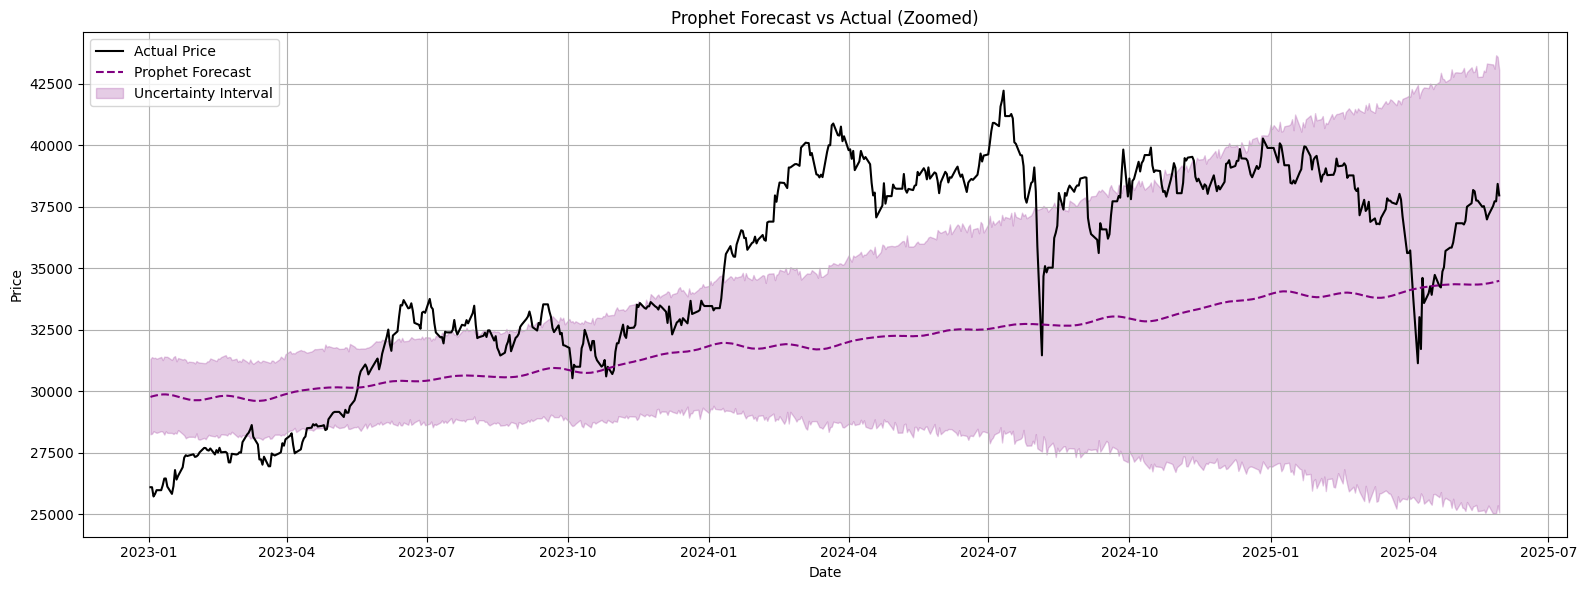

In [25]:
# Extract only the forecasted range (match test data)
forecast_subset = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2025-05-30')]

# Zoomed Plot: Forecast vs Actual
plt.figure(figsize=(16, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label="Actual Price", color="black")
plt.plot(forecast_subset['ds'], forecast_subset['yhat'], label="Prophet Forecast", linestyle='--', color="purple")
plt.fill_between(forecast_subset['ds'], forecast_subset['yhat_lower'], forecast_subset['yhat_upper'], color="purple", alpha=0.2, label="Uncertainty Interval")
plt.title("Prophet Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# Evaluate

y_true = test_prophet['y'].values
y_pred = forecast_subset['yhat'].values

results_prophet = evaluate_forecast(
    y_true,
    y_pred,
    model_name="Prophet"
)

Evaluation for Prophet:
MAE:  3751.73
RMSE: 4376.88
MAPE: 10.27%


### N-BEATS

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Set random seed
torch.manual_seed(69)
np.random.seed(69)

# # Prepare Data
df["LogReturn"] = df["LogReturn"].fillna(0)

train_log_returns = df.loc["2003-01-01":"2022-12-31", "LogReturn"].values
test_data = df["Price"].loc["2023-01-01":"2025-05-30"]
test_log_returns = df["LogReturn"].loc["2023-01-01":"2025-05-30"]
test_dates = test_log_returns.index
last_train_price = df.loc["2022-12-30", "Price"]  # last known price before test

# Define Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, series, backcast_length, forecast_length):
        self.X = []
        self.y = []
        for i in range(backcast_length, len(series) - forecast_length):
            self.X.append(series[i - backcast_length:i])
            self.y.append(series[i:i + forecast_length])
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

backcast_length = 30
forecast_length = 7

train_dataset = TimeSeriesDataset(train_log_returns, backcast_length, forecast_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define N-BEATS Model
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, hidden_size, n_layers, backcast_length, forecast_length):
        super().__init__()
        self.hidden = nn.ModuleList([
            nn.Linear(input_size if i == 0 else hidden_size, hidden_size) for i in range(n_layers)
        ])
        self.relu = nn.ReLU()
        self.theta = nn.Linear(hidden_size, theta_size)
        self.backcast_proj = nn.Linear(theta_size, backcast_length)
        self.forecast_proj = nn.Linear(theta_size, forecast_length)

    def forward(self, x):
        for layer in self.hidden:
            x = self.relu(layer(x))
        theta = self.theta(x)
        backcast = self.backcast_proj(theta)
        forecast = self.forecast_proj(theta)
        return backcast, forecast

class NBeats(nn.Module):
    def __init__(self, input_size, backcast_length, forecast_length,
                 n_blocks=3, hidden_size=128, n_layers=4, theta_size=256):
        super().__init__()
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, theta_size, hidden_size, n_layers,
                        backcast_length, forecast_length) for _ in range(n_blocks)
        ])

    def forward(self, x):
        residual = x
        forecast = 0
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast

In [41]:
# Train Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NBeats(
    input_size=backcast_length,
    backcast_length=backcast_length,
    forecast_length=forecast_length
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
model.train()
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print("Total Loss:", total_loss)
    print("y_batch stats — min:", y_batch.min().item(), "max:", y_batch.max().item(), "mean:", y_batch.mean().item())
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.6f}")

# Recursive Forecast on Test Set
model.eval()
input_window = torch.tensor(train_log_returns[-backcast_length:], dtype=torch.float32).to(device)
predicted_returns = []

predicted_returns = []
steps = len(test_log_returns)

with torch.no_grad():
    input_seq = input_window.clone()
    for _ in range(0, steps, forecast_length):
        forecast = model(input_seq.unsqueeze(0)).squeeze(0).cpu().numpy()
        take = min(forecast_length, steps - len(predicted_returns))
        predicted_returns.extend(forecast[:take])
        input_seq = torch.cat([
            input_seq[forecast_length:],
            torch.tensor(forecast[:take], dtype=torch.float32).to(device)
        ])

# Compute predicted prices
predicted_returns = np.array(predicted_returns)
cumulative_returns = np.cumprod(1 + predicted_returns)
last_train_price_value = float(last_train_price)  # ensure scalar
predicted_prices = last_train_price_value * cumulative_returns

print("Len predicted_returns:", len(predicted_returns))
print("Len cumulative_returns:", len(cumulative_returns))
print("Len test_dates:", len(test_dates))
print("Shape test_dates:", test_dates.shape)
print("Last train price:", last_train_price.shape)

# Make sure test_dates is an Index of length 630
predicted_prices = pd.Series(predicted_prices, index=test_dates)  # This must succeed
actual_prices = df.loc["2023-01-01":"2025-05-30", "Price"].values

Total Loss: 0.06259886440238915
y_batch stats — min: -0.043280381709337234 max: 0.03703823313117027 mean: 0.0006816203822381794
Epoch 1/50 - Loss: 0.000386
Total Loss: 0.03525322365021566
y_batch stats — min: -0.030962953343987465 max: 0.03603124991059303 mean: -5.376722401706502e-05
Epoch 2/50 - Loss: 0.000218
Total Loss: 0.03566643731028307
y_batch stats — min: -0.10116047412157059 max: 0.13234591484069824 mean: 0.0007748499047011137
Epoch 3/50 - Loss: 0.000220
Total Loss: 0.03601795170834521
y_batch stats — min: -0.0484079010784626 max: 0.03703823313117027 mean: 0.001846235478296876
Epoch 4/50 - Loss: 0.000222
Total Loss: 0.03590235151932575
y_batch stats — min: -0.04616476222872734 max: 0.05025998130440712 mean: -0.00022548326523974538
Epoch 5/50 - Loss: 0.000222
Total Loss: 0.03561182392149931
y_batch stats — min: -0.030526435002684593 max: 0.03488875925540924 mean: 0.00011121580610051751
Epoch 6/50 - Loss: 0.000220
Total Loss: 0.03474445451138308
y_batch stats — min: -0.067570514

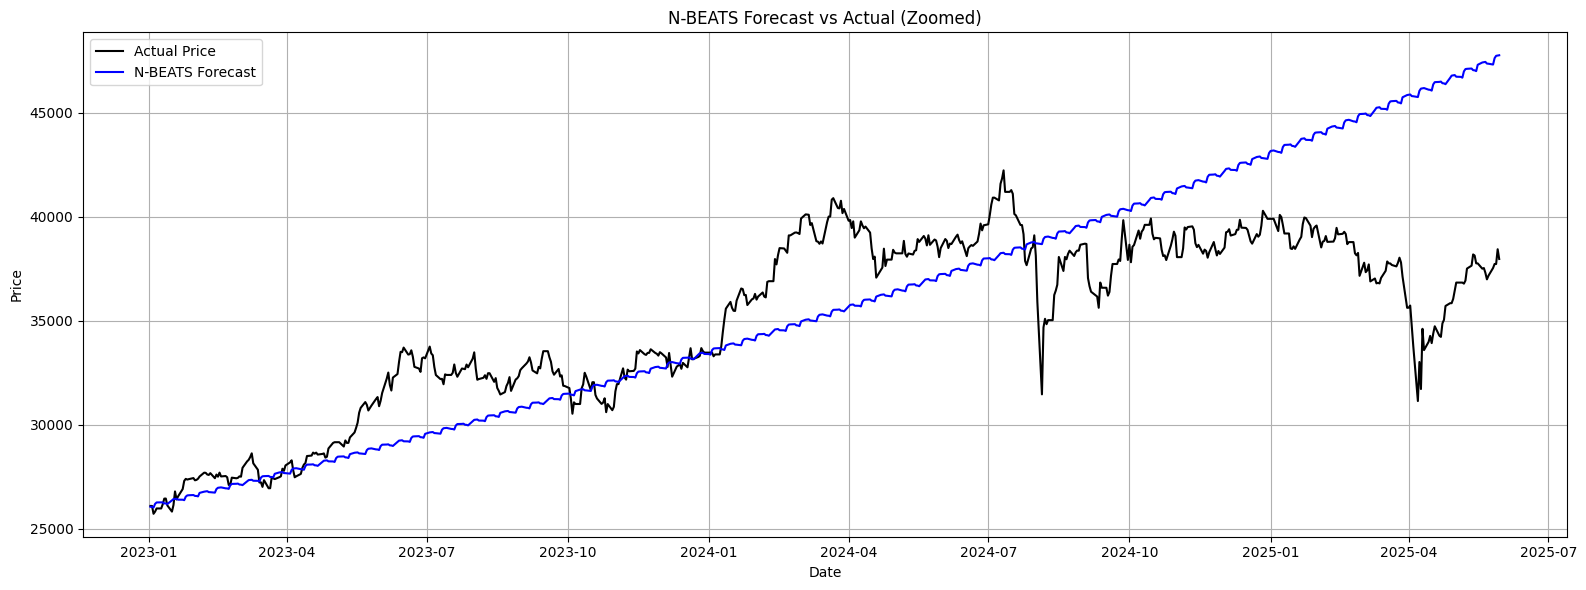

In [42]:
# Plot Zoomed Forecast (2024–2025)
zoom_start = "2023-01-01"
zoom_end = "2025-05-30"
zoom_idx = (test_dates >= zoom_start) & (test_dates <= zoom_end)

plt.figure(figsize=(16, 6))
plt.plot(test_dates[zoom_idx], actual_prices[zoom_idx], label="Actual Price", color="black")
plt.plot(test_dates[zoom_idx], predicted_prices[zoom_idx], label="N-BEATS Forecast", linestyle='-', color="blue")
plt.title("N-BEATS Forecast vs Actual (Zoomed)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
min_len = min(len(predicted_prices), len(actual_prices))
result = evaluate_forecast(
    y_true=actual_prices[:min_len],
    y_pred=predicted_prices.values[:min_len],
    model_name="N-BEATS"
)

Evaluation for N-BEATS:
MAE:  2894.58
RMSE: 4057.21
MAPE: 7.97%
